In [1]:
# Project Scope

# Goals: Predict the height of the waves
# Dataset: Global Ocean Waves Analysis and Forecast (https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_WAV_001_027/download?dataset=cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_202411)
# Analysis: Predict Sea surface wave maximum height (VCMX)

# Results: 0.9981659439482071


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xarray as xr
import netCDF4
from netCDF4 import Dataset
from scipy.io import netcdf

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt



2025-02-23 15:51:13.084725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Reading the file
file = "/Users/jcastropicco/Desktop/cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_1735257954132.nc"
dataset = Dataset(file, mode="r")
#print(dataset.variables.keys())

import numpy as np

features = [
    'latitude', 'longitude', 'VHM0', 'VCMX', 'VHM0_SW1', 'VHM0_SW2',
    'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VMXL', 'VPED',
    'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK'
]


# Creating a baseline DataFrame with latitude and longitude
latitude = dataset.variables["latitude"][:]
longitude = dataset.variables["longitude"][:]
lon, lat = np.meshgrid(longitude, latitude)


# Instantiate the DataFrame with the coordinates
df = pd.DataFrame({
    "latitude": lat.flatten(),
    "longitude": lon.flatten()
})

# Function for cleaning and adding every feature
def agregar_feature(df, feature, dataset, missing_value=-32767):
    try:
        # Extract data from the variable
        data = dataset.variables[feature][:]
        
        # Handling missing values
        data_cleaned = np.where(data == missing_value, np.nan, data)

        # Alligning dimensions
        if data_cleaned.ndim == 3:  # (time, latitude, longitude)
            data_flat = data_cleaned[0, :, :].flatten()
        elif data_cleaned.ndim == 2:  # (latitude, longitude)
            data_flat = data_cleaned.flatten()
        elif data_cleaned.ndim == 1:  # 1D (time, etc.)
            data_flat = np.tile(data_cleaned, len(lat.flatten()) // len(data_cleaned))
        else:
            print(f"Warning: '{feature}' has unsupported dimensions.")
            return df

        # Impute missing values using SimpleImputer
        imputer = SimpleImputer(strategy="mean")
        data_imputed = imputer.fit_transform(data_flat.reshape(-1, 1)).flatten()

        # Adding the column to the DataFrame
        df[feature] = data_imputed

    except KeyError:
        print(f"Error: The variable '{feature}' isn't in the file.")
    except Exception as e:
        print(f"Error while processing '{feature}': {e}")

    return df

# Adding every feature to the DataFrame
for feature in features:
    if feature not in ["latitude", "longitude"]:  # Already added.
        df = agregar_feature(df, feature, dataset)

print(type(df))

# Check the final result
print(df.head())



<class 'pandas.core.frame.DataFrame'>
   latitude   longitude      VHM0      VCMX  VHM0_SW1  VHM0_SW2   VHM0_WW  \
0     -80.0 -180.000000  2.304629  4.316349  1.550056  0.687002  0.941468   
1     -80.0 -179.916672  2.304629  4.316349  1.550056  0.687002  0.941468   
2     -80.0 -179.833328  2.304629  4.316349  1.550056  0.687002  0.941468   
3     -80.0 -179.750000  2.304629  4.316349  1.550056  0.687002  0.941468   
4     -80.0 -179.666672  2.304629  4.316349  1.550056  0.687002  0.941468   

         VMDR    VMDR_SW1   VMDR_SW2  ...      VMXL        VPED      VSDX  \
0  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
1  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
2  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
3  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
4  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   

       VSDY  VTM01_SW1  VTM01_SW2  V

In [5]:
# Separating features and target

y = df.VCMX
X = df.drop(columns="VCMX")

In [59]:
print(y.shape)
print(X.shape)

(8817120,)
(8817120, 20)


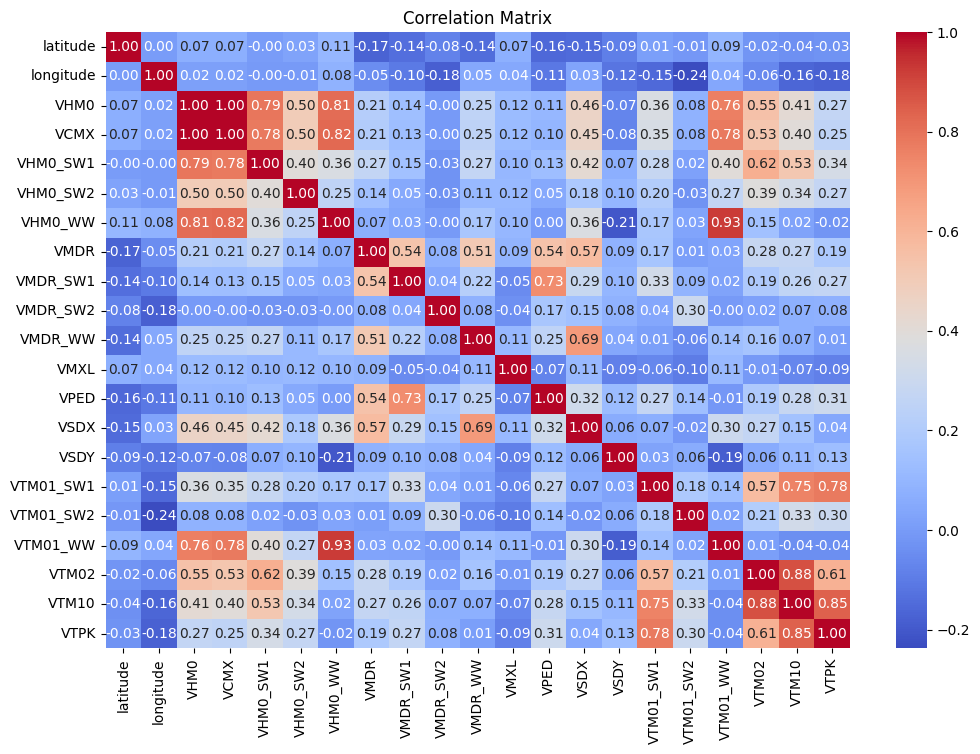

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = df.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [10]:
print(X.head())

   latitude   longitude      VHM0  VHM0_SW1  VHM0_SW2   VHM0_WW        VMDR  \
0     -80.0 -180.000000  2.304629  1.550056  0.687002  0.941468  191.450577   
1     -80.0 -179.916672  2.304629  1.550056  0.687002  0.941468  191.450577   
2     -80.0 -179.833328  2.304629  1.550056  0.687002  0.941468  191.450577   
3     -80.0 -179.750000  2.304629  1.550056  0.687002  0.941468  191.450577   
4     -80.0 -179.666672  2.304629  1.550056  0.687002  0.941468  191.450577   

     VMDR_SW1   VMDR_SW2     VMDR_WW      VMXL        VPED      VSDX  \
0  206.568161  203.08786  170.589401  2.726057  208.474136  0.005888   
1  206.568161  203.08786  170.589401  2.726057  208.474136  0.005888   
2  206.568161  203.08786  170.589401  2.726057  208.474136  0.005888   
3  206.568161  203.08786  170.589401  2.726057  208.474136  0.005888   
4  206.568161  203.08786  170.589401  2.726057  208.474136  0.005888   

       VSDY  VTM01_SW1  VTM01_SW2  VTM01_WW    VTM02     VTM10       VTPK  
0 -0.007733     

In [8]:
from sklearn.preprocessing import StandardScaler

# Scaling variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
print(X_scaled)

[[-1.7312024e+00 -1.7316499e+00 -6.5043685e-07 ... -2.5175470e-06
  -1.9463444e-06  1.2952637e-06]
 [-1.7312024e+00 -1.7308481e+00 -6.5043685e-07 ... -2.5175470e-06
  -1.9463444e-06  1.2952637e-06]
 [-1.7312024e+00 -1.7300460e+00 -6.5043685e-07 ... -2.5175470e-06
  -1.9463444e-06  1.2952637e-06]
 ...
 [ 1.7312024e+00  1.7300463e+00 -6.5043685e-07 ... -2.5175470e-06
  -1.9463444e-06  1.2952637e-06]
 [ 1.7312024e+00  1.7308481e+00 -6.5043685e-07 ... -2.5175470e-06
  -1.9463444e-06  1.2952637e-06]
 [ 1.7312024e+00  1.7316500e+00 -6.5043685e-07 ... -2.5175470e-06
  -1.9463444e-06  1.2952637e-06]]


[[ 0.14269839 -0.48284128  0.32810128 ... -0.06821105  0.00443907
  -0.02573268]
 [ 0.14265645 -0.48269996  0.32813007 ... -0.06819622  0.00444202
  -0.02572116]
 [ 0.1426145  -0.48255858  0.3281589  ... -0.06818139  0.00444497
  -0.02570963]
 ...
 [-0.1426173   0.48255873 -0.32815662 ...  0.06817913 -0.00444551
   0.02570882]
 [-0.14265925  0.48270008 -0.3281278  ...  0.06819396 -0.00444255
   0.02572034]
 [-0.1427012   0.48284143 -0.328099   ...  0.06820879 -0.0044396
   0.02573187]]


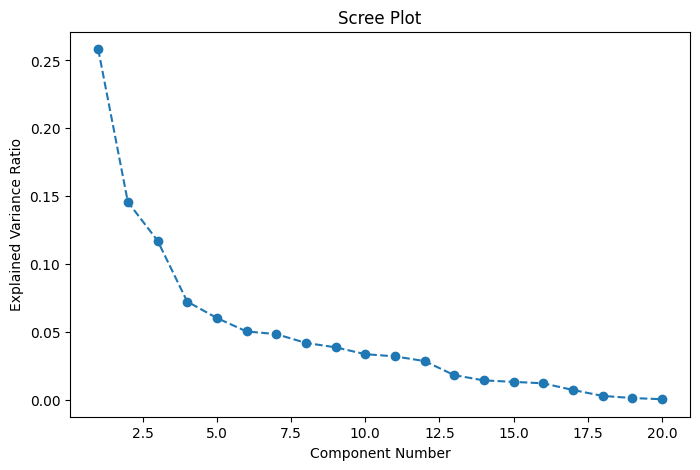

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ajustar PCA sin especificar n_components para obtener todos los componentes
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

print(X_pca_full)

# Varianza explicada por cada componente
explained_variance = pca_full.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.show()

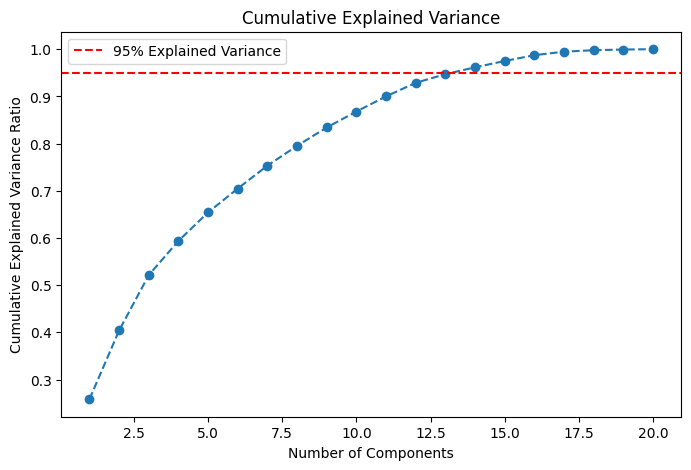

In [14]:
# Varianza acumulativa
cumulative_explained_variance = np.cumsum(explained_variance)

# Gráfico de varianza acumulativa
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.legend(loc='best')
plt.show()

In [15]:
# Determinar el número mínimo de componentes necesarios
n_components_optimal = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Número óptimo de componentes para explicar el 95% de la varianza: {n_components_optimal}")

# Ajustar PCA con el número óptimo de componentes
pca = PCA(n_components=n_components_optimal)
X_pca = pca.fit_transform(X_scaled)

Número óptimo de componentes para explicar el 95% de la varianza: 14


In [16]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction
pca = PCA(n_components=14)  # Elegir el número de componentes principales
X_pca = pca.fit_transform(X_scaled)

In [60]:
print(y.shape)

(8817120,)


In [61]:
# Train-test data split 
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

In [62]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7053696, 14)
(1763424, 14)
(7053696,)
(1763424,)


In [63]:
model = Sequential(
    [
        tf.keras.Input(shape=(X_pca.shape[1],)),
        Dense(units=10, activation="relu"),
        Dense(units=5, activation="relu"),
        Dense(units=1, activation="linear")
    ], name="my_model"
)

In [64]:
print(model.summary())

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211 (844.00 B)

 Trainable params: 211 (844.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [66]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    x_train, y_train,
    epochs=8
)

Epoch 1/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 236s 1ms/step - loss: 0.1290
Epoch 2/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 220s 999us/step - loss: 0.0226
Epoch 3/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 222s 1ms/step - loss: 0.0222
Epoch 4/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 229s 1ms/step - loss: 0.0221
Epoch 5/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 248s 1ms/step - loss: 0.0219
Epoch 6/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 270s 1ms/step - loss: 0.0220
Epoch 7/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 246s 1ms/step - loss: 0.0220
Epoch 8/8
220428/220428 ━━━━━━━━━━━━━━━━━━━━ 241s 1ms/step - loss: 0.0219


In [67]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635 (2.48 KB)

 Trainable params: 211 (844.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 424 (1.66 KB)

In [68]:
predictions = model.predict(x_test)

55107/55107 ━━━━━━━━━━━━━━━━━━━━ 32s 573us/step


In [69]:
print(f"predictions = {predictions}")

predictions = [[4.087883 ]
 [4.3130774]
 [4.2818847]
 ...
 [5.5237865]
 [4.2889824]
 [4.931781 ]]


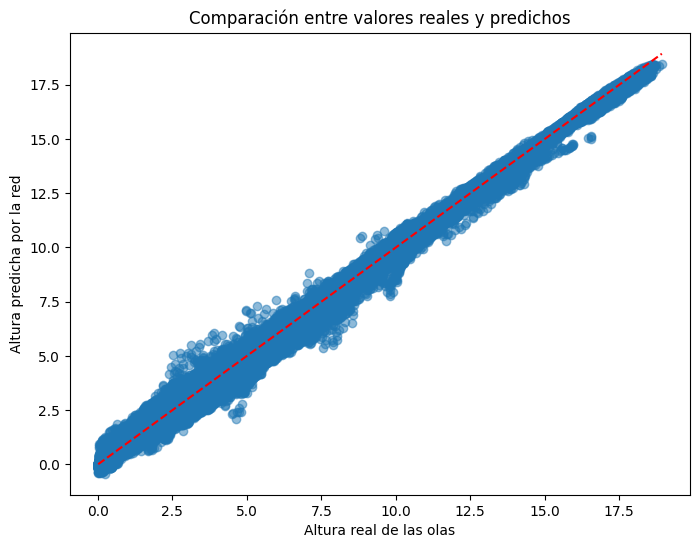

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.xlabel("Altura real de las olas")
plt.ylabel("Altura predicha por la red")
plt.title("Comparación entre valores reales y predichos")
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

MSE: 0.0215
MAE: 0.0850


In [72]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9931


In [75]:
print(f"Tamaño de x_test: {len(x_test)}")
print(f"Tamaño de y_test: {len(y_test)}")
print(f"Tamaño de predictions: {len(predictions)}")


print(f"Forma de x_test: {x_test.shape}")
print(f"Forma de y_test: {y_test.shape}")
print(f"Forma de predictions: {predictions.shape}")


Tamaño de x_test: 1763424
Tamaño de y_test: 1763424
Tamaño de predictions: 1763424
Forma de x_test: (1763424, 14)
Forma de y_test: (1763424,)
Forma de predictions: (1763424, 1)


In [78]:
from sklearn.metrics import mean_squared_error, r2_score

# Predicciones en entrenamiento y prueba
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Convertir a 1D si es necesario
y_train_pred = y_train_pred.ravel()
y_test_pred = y_test_pred.ravel()

# Calcular métricas
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"MSE Entrenamiento: {mse_train:.4f}, MSE Prueba: {mse_test:.4f}")
print(f"R² Entrenamiento: {r2_train:.4f}, R² Prueba: {r2_test:.4f}")


220428/220428 ━━━━━━━━━━━━━━━━━━━━ 166s 752us/step
55107/55107 ━━━━━━━━━━━━━━━━━━━━ 54s 974us/step
MSE Entrenamiento: 0.0215, MSE Prueba: 0.0215
R² Entrenamiento: 0.9931, R² Prueba: 0.9931


In [83]:
#Reading the file
file_test = "/Users/jcastropicco/Downloads/cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_1740363843961.nc"
dataset_test = Dataset(file, mode="r")
#print(dataset.variables.keys())

# Instantiate the DataFrame with the coordinates
df_test = pd.DataFrame({
    "latitude": lat.flatten(),
    "longitude": lon.flatten()
})

# Adding every feature to the DataFrame
for feature in features:
    if feature not in ["latitude", "longitude"]:  # Already added.
        df_test = agregar_feature(df_test, feature, dataset)

print(type(df_test))

# Check the final result
print(df_test.head())



<class 'pandas.core.frame.DataFrame'>
   latitude   longitude      VHM0      VCMX  VHM0_SW1  VHM0_SW2   VHM0_WW  \
0     -80.0 -180.000000  2.304629  4.316349  1.550056  0.687002  0.941468   
1     -80.0 -179.916672  2.304629  4.316349  1.550056  0.687002  0.941468   
2     -80.0 -179.833328  2.304629  4.316349  1.550056  0.687002  0.941468   
3     -80.0 -179.750000  2.304629  4.316349  1.550056  0.687002  0.941468   
4     -80.0 -179.666672  2.304629  4.316349  1.550056  0.687002  0.941468   

         VMDR    VMDR_SW1   VMDR_SW2  ...      VMXL        VPED      VSDX  \
0  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
1  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
2  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
3  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
4  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   

       VSDY  VTM01_SW1  VTM01_SW2  V

In [95]:
from sklearn.preprocessing import StandardScaler

# Separating features and target

y_new_test = df.VCMX
X_new_test = df.drop(columns="VCMX")

# Scaling variables
scaler_test = StandardScaler()
X_test_scaled = scaler_test.fit_transform(X_new_test)

# Ajustar PCA sin especificar n_components para obtener todos los componentes
pca_full_test = PCA()
X_pca_full_test = pca_full_test.fit_transform(X_test_scaled)

print(X_pca_full_test)

from sklearn.decomposition import PCA

# PCA dimensionality reduction
pca_test = PCA(n_components=14)  # Elegir el número de componentes principales
X_pca_test = pca_test.fit_transform(X_test_scaled)

[[ 0.14269839 -0.48284128  0.32810128 ... -0.06821105  0.00443907
  -0.02573268]
 [ 0.14265645 -0.48269996  0.32813007 ... -0.06819622  0.00444202
  -0.02572116]
 [ 0.1426145  -0.48255858  0.3281589  ... -0.06818139  0.00444497
  -0.02570963]
 ...
 [-0.1426173   0.48255873 -0.32815662 ...  0.06817913 -0.00444551
   0.02570882]
 [-0.14265925  0.48270008 -0.3281278  ...  0.06819396 -0.00444255
   0.02572034]
 [-0.1427012   0.48284143 -0.328099   ...  0.06820879 -0.0044396
   0.02573187]]


In [96]:
new_predictions = model.predict(X_pca_test)

print(new_predictions)

275535/275535 ━━━━━━━━━━━━━━━━━━━━ 144s 522us/step
[[4.3088546]
 [4.3088713]
 [4.308888 ]
 ...
 [4.3091245]
 [4.30909  ]
 [4.3090563]]


In [97]:
print(new_predictions.shape)
print(y_new_test.shape)

(8817120, 1)
(8817120,)


In [98]:
# Calcular métricas
mse_test = mean_squared_error(y_new_test, new_predictions)

r2_test = r2_score(y_new_test, new_predictions)

print(f"MSE Prueba: {mse_test:.4f}")
print(f"R² Prueba: {r2_test:.4f}")


MSE Prueba: 0.0215
R² Prueba: 0.9931


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


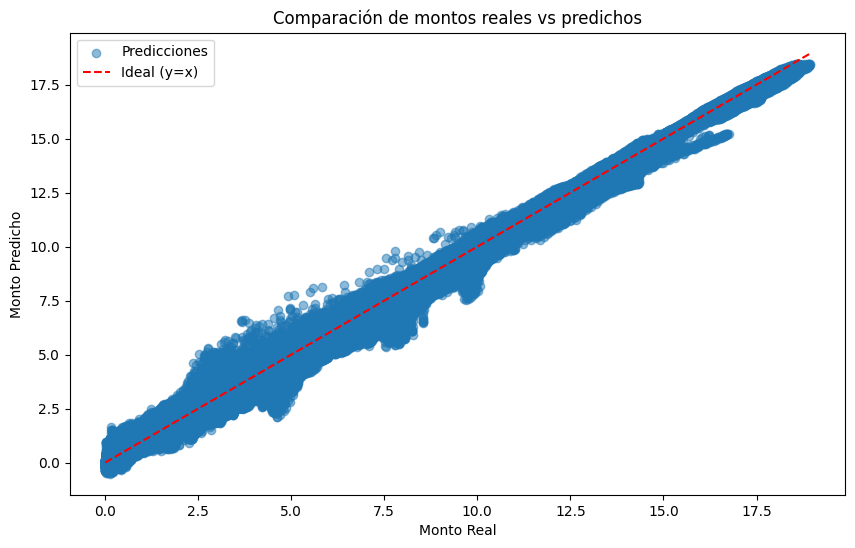

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_new_test, new_predictions, alpha=0.5, label="Predicciones")
plt.plot([min(y_new_test), max(y_new_test)], [min(y_new_test), max(y_new_test)], color='red', linestyle='dashed', label="Ideal (y=x)")

plt.xlabel("Monto Real")
plt.ylabel("Monto Predicho")
plt.title("Comparación de montos reales vs predichos")
plt.legend()
plt.show()


In [102]:
print(new_predictions.shape)
print(y_new_test.shape)

print(new_predictions)
print(y_new_test)


(8817120, 1)
(8817120,)
[[4.3088546]
 [4.3088713]
 [4.308888 ]
 ...
 [4.3091245]
 [4.30909  ]
 [4.3090563]]
0          4.316349
1          4.316349
2          4.316349
3          4.316349
4          4.316349
             ...   
8817115    4.316349
8817116    4.316349
8817117    4.316349
8817118    4.316349
8817119    4.316349
Name: VCMX, Length: 8817120, dtype: float32
